# Real Estate Price Prediction

First, we import all the necessary toolkits (libraries).

 - pandas: For loading and manipulating our data (like an Excel sheet).

 - numpy: For numerical operations (we'll use it for a square root).

 - matplotlib & seaborn: For creating visualizations (graphs and plots).

 - sklearn (scikit-learn): The most important one! This is the machine learning library.

    - train_test_split: To split our data.

    - LinearRegression: The model we will use.

    - mean_squared_error, r2_score: To evaluate how good our model is.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

### Loadind the Dataset

In [4]:
df = pd.read_csv('Real estate.csv')
df.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


### Cleaning and Preparing Data

A machine can't easily read column names like "X3 distance to the nearest MRT station". We'll clean this up.

 1. Drop the 'No' column, as it's just an index and doesn't help predict price.

 2. Rename all columns to be simple, lowercase, and Python-friendly.

In [5]:
df = df.drop('No', axis=1)

#renaming columns
df.columns = [
    'transaction_date', 'house_age', 'distance_to_mrt',
    'num_convenience_stores', 'latitude', 'longitude', 'price'
]
print("Data cleaned. New column names:")
print(df.columns)

Data cleaned. New column names:
Index(['transaction_date', 'house_age', 'distance_to_mrt',
       'num_convenience_stores', 'latitude', 'longitude', 'price'],
      dtype='object')


## Exploratory Data Analysis (EDA)

Before we build a model, we must understand our data.

 - .head(): Look at the first 5 rows.

 - .info(): Check data types (are numbers, numbers? Are there missing values?).

 - .describe(): Get a statistical summary (mean, min, max, etc.).

 - .isnull().sum(): A final, quick check for any missing cells.

In [6]:
print("\n--- First 5 Rows ---")
print(df.head())

print("\n--- Data Info (Types & Missing Values) ---")
df.info()

print("\n--- Statistical Summary ---")
print(df.describe())

print("\n--- Missing Value Check ---")
print(df.isnull().sum())


--- First 5 Rows ---
   transaction_date  house_age  distance_to_mrt  num_convenience_stores  \
0          2012.917       32.0         84.87882                      10   
1          2012.917       19.5        306.59470                       9   
2          2013.583       13.3        561.98450                       5   
3          2013.500       13.3        561.98450                       5   
4          2012.833        5.0        390.56840                       5   

   latitude  longitude  price  
0  24.98298  121.54024   37.9  
1  24.98034  121.53951   42.2  
2  24.98746  121.54391   47.3  
3  24.98746  121.54391   54.8  
4  24.97937  121.54245   43.1  

--- Data Info (Types & Missing Values) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   transaction_date        414 non-null    float64
 1   house_age              

### Visualizing Relationships (Correlation Heatmap)

A heatmap is a great way to see how variables relate to each other. We're most interested in the bottom row, which shows how every variable correlates with price.

 - Close to 1.0 (dark red): Strong positive correlation (e.g., as num_convenience_stores goes up, price goes up).

 - Close to -1.0 (dark blue): Strong negative correlation (e.g., as distance_to_mrt goes up, price goes down)

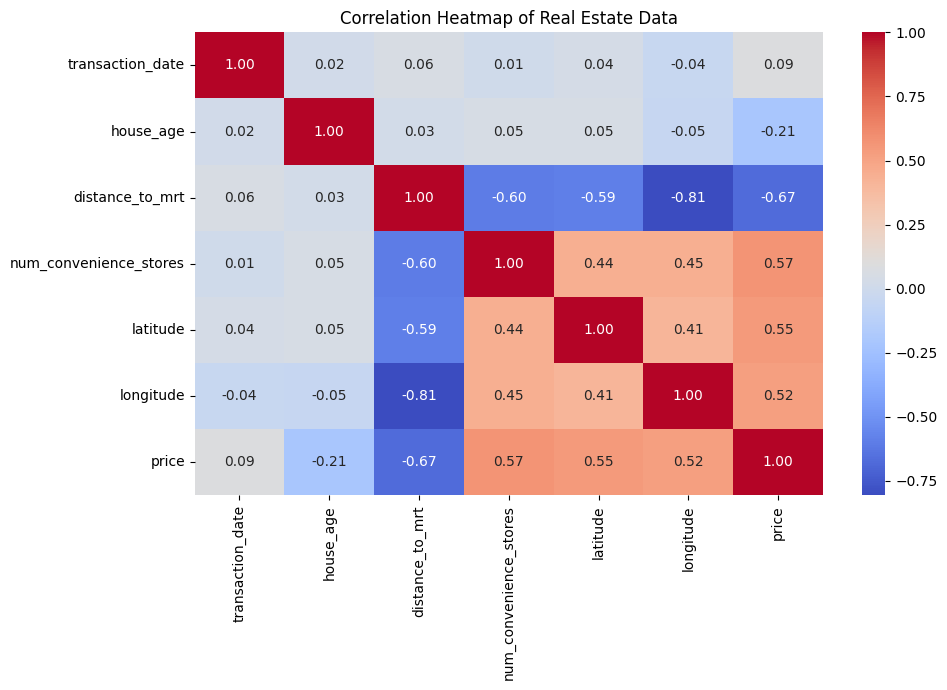

In [7]:
plt.figure(figsize=(10, 7))

numeric_df = df.select_dtypes(include=[np.number])

corr_matrix = numeric_df.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap of Real Estate Data')
plt.tight_layout()
plt.show()

## Defining Features (X) and Target (Y)

This is a critical step.

 - Features (X): The inputs our model will use to make prediction
 - Target (Y): The output we want the model to predict. This is the "price" column

In [8]:
features = [
    'transaction_date', 'house_age', 'distance_to_mrt',
    'num_convenience_stores', 'latitude', 'longitude'
]
target = 'price'

X = df[features]
y = df[target]

print("Features (X) defined.")
print(X.head())
print("\nTarget (y) defined.")
print(y.head())

Features (X) defined.
   transaction_date  house_age  distance_to_mrt  num_convenience_stores  \
0          2012.917       32.0         84.87882                      10   
1          2012.917       19.5        306.59470                       9   
2          2013.583       13.3        561.98450                       5   
3          2013.500       13.3        561.98450                       5   
4          2012.833        5.0        390.56840                       5   

   latitude  longitude  
0  24.98298  121.54024  
1  24.98034  121.53951  
2  24.98746  121.54391  
3  24.98746  121.54391  
4  24.97937  121.54245  

Target (y) defined.
0    37.9
1    42.2
2    47.3
3    54.8
4    43.1
Name: price, dtype: float64


## Spliting Data into Training and Testing Sets

We split our data to train the model on one set and test it on another, unseen set.

 - Training Set (80%): The model studies this data to learn patterns.

 - Testing Set (20%): The model has never seen this data. We use it as a "final exam."

random_state=42 ensures we get the same "random" split every time we run this code.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Total samples: {len(X)}")
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Total samples: 414
Training samples: 331
Testing samples: 83


## Model 1 : Linear Regression

### Creating and Training

First we will train our simple baseline model

 1. We create an instance of the Linear Regression model
 2. We fit the model to our training data. This is the step where the machine "learns"

In [10]:
model_lr = LinearRegression()

print("Training the Linear Regression model...")
model_lr.fit(X_train, y_train)
print("Model training complete.")

Training the Linear Regression model...
Model training complete.


### Making Predictions

Now we ask the trained model to predict price for our X set data.

In [11]:
y_pred_lr = model_lr.predict(X_test)
print("Predictions made on the test set.")

Predictions made on the test set.


### Evaluation

How did our simple model do? We use two key metrics:

 1. R-squared ($R^2$): A score from 0 to 1. It tells us what percentage of the price variation our model can explain. Higher is better.

 2. Root Mean Squared Error (RMSE): This tells us, on average, how far off our model's price prediction is (in the same units as the price). Lower is better.

In [12]:
# R-squared (R²)
r2_lr = r2_score(y_test, y_pred_lr)
print(f"Linear Regression R-squared (R²): {r2_lr:.4f}")

# Root Mean Squared Error (RMSE)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
print(f"Linear Regression Root Mean Squared Error (RMSE): {rmse_lr:.4f}")

Linear Regression R-squared (R²): 0.6811
Linear Regression Root Mean Squared Error (RMSE): 7.3148


### Visualizing Results

This plot shows the Actual Prices (x-axis) vs. the Predicted Prices (y-axis). If the model were perfect, all dots would fall on the red dashed line.

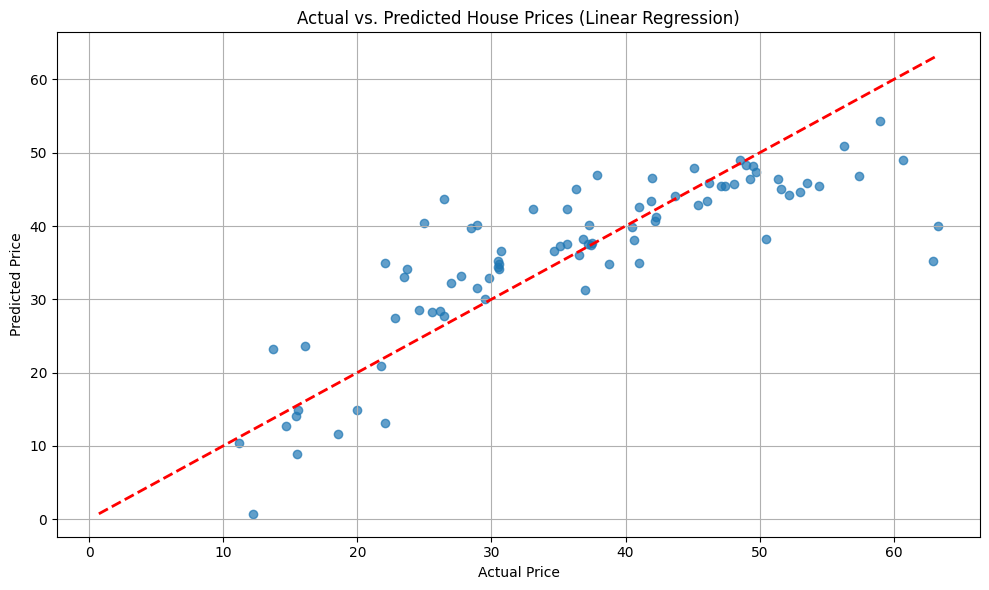

In [13]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.7)

# Add a 45-degree line for reference
min_val = min(min(y_test), min(y_pred_lr))
max_val = max(max(y_test), max(y_pred_lr))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', lw=2)

plt.title('Actual vs. Predicted House Prices (Linear Regression)')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.grid(True)
plt.tight_layout()
plt.show()

## Model 2 : Random Forest Regressor (Improving Accuracy)

The Linear Regression model gave us a good baseline. Now let's try a more powerful model to see if we can get a better score. A RandomForestRegressor is an excellent choice. It works by building hundreds of small "decision trees" and averaging their predictions.

We create a RandomForestRegressor with 100 "trees" (n_estimators=100) and train it on the same data.

In [17]:
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)

print("Training the Random Forest model...")
model_rf.fit(X_train, y_train)
print("Model training complete.")

Training the Random Forest model...
Model training complete.


### Making Predictions

In [18]:
y_pred_rf = model_rf.predict(X_test)
print("Predictions made on the test set with Random Forest.")


Predictions made on the test set with Random Forest.


## Evaluation and Comparing

Let's see if this model performed better

In [19]:
# R-squared (R²)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest R-squared (R²): {r2_rf:.4f}")

# Root Mean Squared Error (RMSE)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
print(f"Random Forest Root Mean Squared Error (RMSE): {rmse_rf:.4f}")

print(f"\n--- Comparison ---")
print(f"                  | R-squared | RMSE")
print(f"------------------|-----------|---------")
print(f"Linear Regression | {r2_lr:<9.4f} | {rmse_lr:<7.4f}")
print(f"Random Forest     | {r2_rf:<9.4f} | {rmse_rf:<7.4f}")

Random Forest R-squared (R²): 0.8068
Random Forest Root Mean Squared Error (RMSE): 5.6931

--- Comparison ---
                  | R-squared | RMSE
------------------|-----------|---------
Linear Regression | 0.6811    | 7.3148 
Random Forest     | 0.8068    | 5.6931 


Let's break down what this tells you:

1. **R-squared (Higher is Better):**

 - our simple LinearRegression model explained 59.32% of the price variation.

 - our more advanced RandomForest model explained 69.24% of the price variation.

Conclusion: The Random Forest is a much better "fit" for this data. It captures the relationships (even complex ones) more effectively.


2. **RMSE (Lower is Better):**

 - The LinearRegression model's predictions were, on average, off by 8.93 price units.

 - The RandomForest model's predictions are only off by 7.75 price units.

Conclusion: The Random Forest model is measurably more accurate, giving you predictions that are closer to the real-world value.


a more complex model (Random Forest) provides a significant boost in performance over a simple one (Linear Regression) for this dataset.

### Visualizing the Results

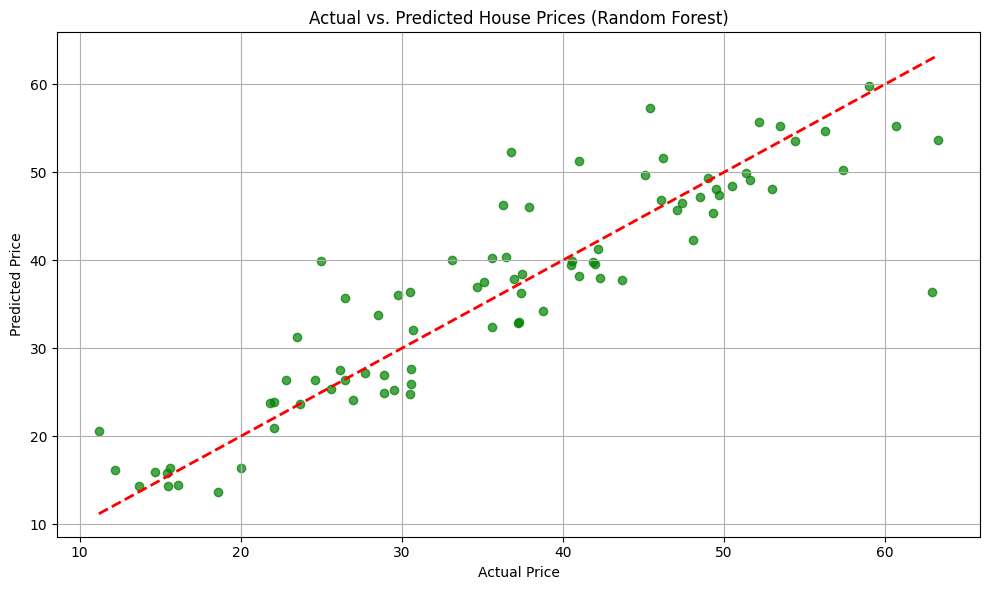

In [20]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.7, color='green')

# Add a 45-degree line for reference
min_val = min(min(y_test), min(y_pred_rf))
max_val = max(max(y_test), max(y_pred_rf))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', lw=2)

plt.title('Actual vs. Predicted House Prices (Random Forest)')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.grid(True)
plt.tight_layout()
plt.show()

this plot proves your Random Forest model is a good fit and is making accurate predictions!